# Drawing Flux Footprints

## Dependencies / Optional Mounting

In [ ]:
import pathlib
import sys

sys.path.append('/home/rfishman/Desktop/footprints/src')

#import dependencies
from core import FPP

import pandas as pd
import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from ipython.display import display # type: ignore
from pyproj import Transformer
from rasterio import features
from rasterio.features import shapes
from rasterio.transform import from_origin, xy
from shapely.geometry import Polygon, Point, shape
from shapely.ops import unary_union
from shapelysmooth import taubin_smooth

In [2]:
try:
    from google.colab import drive # type: ignore
    drive.mount('/content/drive')
except ImportError:
    pass

In [33]:
latitude, longitude = 36.456667, 121.382222 #tower location
hemisphere = 'north'

In [32]:
def cleandataFXN(crop_df):
    zm = 2.0  # Height from ground in meters
    d = 0.335  # Displacement in meters
    z0 = 0.1  # Roughness length in meters

    # Read CSV
    # df = pd.read_csv(crop_df)

    # Select and copy columns
    crop1_df = crop_df[['date_time', 'WS', 'USTAR', 'WD', 'V_SIGMA', 'MO_LENGTH']].copy()

    # Add columns
    crop1_df['zm'] = zm
    crop1_df['d'] = d
    crop1_df['z0'] = z0

    # Convert to datetime format
    crop1_df['date_time'] = pd.to_datetime(crop1_df['date_time'])

    # Separate year month day etc
    crop1_df['yyyy'] = crop1_df['date_time'].dt.year
    crop1_df['mm'] = crop1_df['date_time'].dt.month
    crop1_df['day'] = crop1_df['date_time'].dt.day
    crop1_df['HH'] = crop1_df['date_time'].dt.hour
    crop1_df['MM'] = crop1_df['date_time'].dt.minute

    # Rearrange columns
    crop2_df = crop1_df[['yyyy', 'mm', 'day', 'HH', 'MM', 'zm', 'd', 'z0', 'WS', 'MO_LENGTH', 'V_SIGMA', 'USTAR', 'WD']].copy()

    # Rename columns
    crop3_df = crop2_df.rename(columns={'WS': 'u_mean', 'MO_LENGTH': 'L', 'V_SIGMA': 'sigma_v', 'USTAR': 'u_star', 'WD': 'wind_dir'})

    # Subset the data to only include hours between 9 AM and 3 PM (inclusive)
    cropFinal_df = crop3_df[(crop3_df['HH'] > 8) & (crop3_df['HH'] < 16)]

    return cropFinal_df

In [37]:
utmzone = int((longitude + 180) / 6) + 1  # calculate UTM zone based on longitude
utm_crs = f"+proj=utm +zone={utmzone} +datum=WGS84 +units=m +no_defs"  # create UTM CRS

def convert_to_utm(lat_lon):
    transformer = Transformer.from_crs("epsg:4326", utm_crs)
    
    lat, lon = lat_lon
    easting, northing = transformer.transform(lat, lon)
    return easting, northing  # meters from bottom left of UTM zone

In [45]:
# Find the maximum overlap value directly inside the function
def raster_to_polygon(raster, transform, threshold_ratio = 0.8):
    max_overlaps = np.max(raster)  # Find max directly in the function
    mask = raster > (max_overlaps * threshold_ratio)  # Mask based on threshold (80% of max)
    shapes_gen = shapes(raster, mask = mask, transform = transform)  # Generate shapes

    # Convert shapes to polygons
    return [shape(geom) for geom, _ in shapes_gen]

## Data Cleanup & Formatting

### Sourcing

In [28]:
data_source = widgets.Text(
    placeholder="B_SanLuis",
    description="Data source:",
    layout=widgets.Layout(width='100%'),
    continious_update=True
)
crop_concern = widgets.Text(
    placeholder="Lettuce",
    description="Crop concern:",
    layout=widgets.Layout(width='100%'),
    continious_update=True
)

display(data_source, crop_concern)

Text(value='', description='Data source:', layout=Layout(width='100%'), placeholder='B_SanLuis')

Text(value='', description='Crop concern:', layout=Layout(width='100%'), placeholder='Lettuce')

In [36]:
data_source_val = data_source.value if data_source.value else data_source.placeholder
crop_concern_val = crop_concern.value if crop_concern.value else crop_concern.placeholder

colab_data = pathlib.Path(f'/content/home/MyDrive/{data_source_val}/Data/')
local_data = pathlib.Path(f"../data/{data_source_val}/Data/")
DIR = colab_data if colab_data.exists() else local_data

in_suffix = '_30min_piqc.csv' if crop_concern_val == 'Broccoli' else '_30min_gapfilled.csv'

in_file = DIR / f"0_Input_Datasets/{crop_concern_val}/{crop_concern_val + '2024'}{in_suffix}"
out_file = DIR / f"1_Intermediate_Datasets/{crop_concern_val}/{crop_concern_val + '2024'}FP.csv"
json_out = DIR / F"1_Intermediate_Datasets/{crop_concern_val}/Json"

print('Input file is:', str(in_file))
print('Output file is:', str(out_file))
print('JSON file is: ', str(json_out))

Input file is: ../data/B_SanLuis/Data/0_Input_Datasets/Lettuce/Lettuce2024_30min_gapfilled.csv
Output file is: ../data/B_SanLuis/Data/1_Intermediate_Datasets/Lettuce/Lettuce2024FP.csv
JSON file is:  ../data/B_SanLuis/Data/1_Intermediate_Datasets/Lettuce/Json


### Cleaning

In [30]:
df = pd.read_csv(in_file)
clean_df = cleandataFXN(df)
clean_df.to_csv(out_file, index=False)
clean_df

,yyyy,mm,day,HH,MM,zm,d,z0,u_mean,L,sigma_v,u_star,wind_dir
0,2024,4,10,11,0,2.0,0.335,0.1,1.181668,-0.344012,0.532709,0.093689,231.0488
1,2024,4,10,11,30,2.0,0.335,0.1,1.051614,-2.452590,0.812059,0.180846,300.0215
2,2024,4,10,12,0,2.0,0.335,0.1,2.245800,-4.511233,1.064353,0.230961,283.9656
3,2024,4,10,12,30,2.0,0.335,0.1,3.719224,-6.171940,1.186945,0.245948,290.1801
4,2024,4,10,13,0,2.0,0.335,0.1,4.239919,-9.471722,1.117503,0.283576,297.5996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,2024,6,14,11,0,2.0,0.335,0.1,4.016666,-22.064510,1.001041,0.351602,286.4773
3121,2024,6,14,11,30,2.0,0.335,0.1,5.030773,-34.082950,1.145409,0.418396,290.0015
3122,2024,6,14,12,0,2.0,0.335,0.1,6.052983,-42.038580,1.314996,0.463808,285.5940
3123,2024,6,14,12,30,2.0,0.335,0.1,6.912714,-63.658600,1.439849,0.529082,286.6799


yyyy - year\
mm   - month [1-12]\
day  - day [1-31]\
HH   - hour [1-24]\
MM   - minutes [0:30]\
zm   - height from ground m [2.0]\
d    - displacement m [.67*.5]\
z0   - roughness length m [.1]\
u_mean - avg wind speed m/s *** used WS\
L    - obukhov length m *** used MO_LENGTH\
sigma_v - lateral velocity m/s *** used v_sigma\
u_star - friction velocity m/s *** used USTAR\
wind_dir - wind direction in deg *** used WD

## Visualizing

In [35]:
towercoordinates = np.array([[latitude, longitude]])  # tower's lat/lon
# Convert tower coordinates to UTM
tower_utm_coordinates = np.apply_along_axis(convert_to_utm, axis = 1, arr = towercoordinates)
easting, northing = tower_utm_coordinates[0]

### Drawing Footprints

In [38]:
# Initialize an empty list to hold all the polygons
polygons = []

# Load crop data
crop_df = pd.read_csv(out_file)  # CSV contains 1048 rows

# Limit rows processed (for memory reasons) ~ 300 max
for index, row in crop_df.iterrows():
    if index >= 300:  # type: ignore # set to and # of rows
        break
    try:
        # Initialize the Footprint Model (FFP)
        TestFPmodel = FPP(
            zm = row['zm'],
            z0 = row['z0'],
            umean = row['u_mean'],
            h = 2000,
            ol = row['L'],
            sigmav = row['sigma_v'],
            ustar = row['u_star'],
            wind_dir = row['wind_dir'],
            rs = [90],
            fig = False  # set to True if you want to plot the figure
        )

        # Extract xr, yr coordinates and shift them by tower's UTM coordinates
        xr = np.array(TestFPmodel['xr'][0]) + easting
        yr = np.array(TestFPmodel['yr'][0]) + northing

        # Create Polygon from xr, yr coordinate pairs
        polygon_coords = Polygon(zip(xr, yr))

        # Append the polygon to the list
        polygons.append(polygon_coords)

    except KeyError as e:
        print(f"KeyError in row {index}: {e}")
    except ValueError as e:
        print(f"ValueError in row {index}: {e}")
    except Exception as e:
        print(f"Error in row {index}: {e}")
        continue

# Create GeoDataFrame from all collected polygons at once
gdf = gpd.GeoDataFrame(geometry = polygons, crs = utm_crs) # type: ignore

# Optionally save the intermediates as GeoJSON
Json_output_path = json_out / (crop_concern_val + '_all.geojson')
gdf.to_file(Json_output_path, driver='GeoJSON')
print(f"All polygons saved as {Json_output_path}")

/home/rfishman/Desktop/footprints/src/core.py:86: UserWarning: Both z0 and umean provided. Using z0.
  warn("Both z0 and umean provided. Using z0.", category=UserWarning)


ValueError in row 0: ustar (friction velocity) must be at least 0.1.
ValueError in row 11: np.log(zm / z0) - psi_f must be greater than 0.
ValueError in row 12: np.log(zm / z0) - psi_f must be greater than 0.
ValueError in row 99: ustar (friction velocity) must be at least 0.1.
Error in row 102: 'NoneType' object is not iterable
ValueError in row 109: ustar (friction velocity) must be at least 0.1.
ValueError in row 151: ustar (friction velocity) must be at least 0.1.
ValueError in row 152: ustar (friction velocity) must be at least 0.1.
Error in row 154: 'NoneType' object is not iterable
ValueError in row 191: ustar (friction velocity) must be at least 0.1.
ValueError in row 290: np.log(zm / z0) - psi_f must be greater than 0.
ValueError in row 291: np.log(zm / z0) - psi_f must be greater than 0.
ValueError in row 292: np.log(zm / z0) - psi_f must be greater than 0.
ValueError in row 293: np.log(zm / z0) - psi_f must be greater than 0.
ValueError in row 294: np.log(zm / z0) - psi_f mu

In [39]:
# Check if there is anything in gdf
if not gdf.empty:
    # Find furthest extent of polygons
    minx, miny, maxx, maxy = gdf.union_all().bounds
    print(f"Overall extent: minx = {minx}, miny = {miny}, maxx = {maxx}, maxy = {maxy}")
else:
    print("No polygons were processed.")

Overall extent: minx = 354935.62609456165, miny = 4035714.252641908, maxx = 355144.7055559816, maxy = 4035925.165546623


In [40]:
# Input desired resolution
resolution = 1  # meters per pixel
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

# Create array to hold all individual rasters
accumulated_raster = np.zeros((height, width), dtype=np.uint8)

# Set transformation matrix based on the bounding box
transform = from_origin(minx, maxy, resolution, resolution)

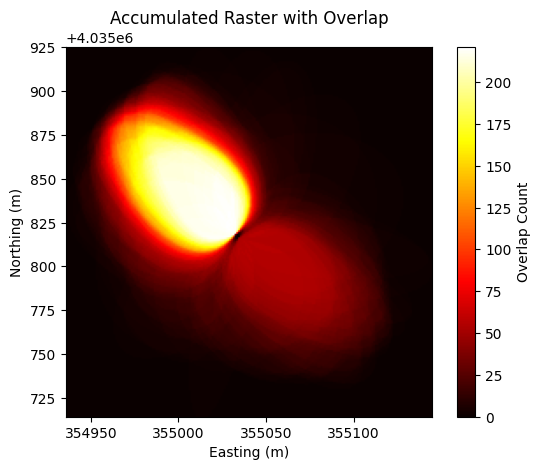

In [41]:
# Iterate over all polygons in the GeoDataFrame and rasterize them
for index, row in gdf.iterrows():
    try:
        polygon = [row['geometry']]  # Convert polygon to list
        rasterized = features.rasterize(
            polygon,
            out_shape = (height, width),
            fill = 0,
            transform = transform
        )

        # Ensure rasterized data matches the dtype of the accumulated_raster
        rasterized = rasterized.astype(accumulated_raster.dtype)

        # Accumulate the rasterized polygon to the overall raster
        accumulated_raster += rasterized

    except KeyError as e:
        print(f"KeyError in row {index}: {e}")
    except Exception as e:
        print(f"Error in row {index}: {e}")
        continue

# Plot the accumulated raster with chosen colormap
fig, ax = plt.subplots()
# Set colormap (adjust as needed; 'hot' is currently used, but you can change this)
cax = ax.imshow(accumulated_raster, cmap = 'hot', extent = (minx, maxx, miny, maxy))

# Set labels and title
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.colorbar(cax, ax = ax, label = 'Overlap Count')
plt.title('Accumulated Raster with Overlap')

# Display the plot
plt.show()

### Output Cleaning

In [42]:
# Identify all non-zero pixels and their values
non_zero_pixels = np.nonzero(accumulated_raster)  # Returns indices of non-zero pixels
non_zero_values = accumulated_raster[non_zero_pixels]  # Extract the actual values of non-zero pixels

# Get the corresponding coordinates (x, y) for each non-zero pixel
xs, ys = xy(transform, non_zero_pixels[0], non_zero_pixels[1])

# Create Point geometries from x, y coordinates
geometries = [Point(x, y) for x, y in zip(xs, ys)]

# Create a GeoDataFrame to hold the geometries and the overlap counts
accumulated_raster_non_zero = gpd.GeoDataFrame({
    'geometry': geometries,
    'overlap_count': non_zero_values
}, crs = utm_crs) # type: ignore

#### Plot

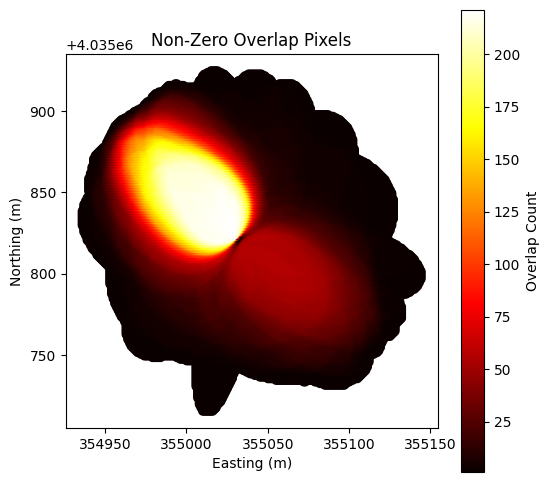

In [43]:
# Plot the non-zero overlap pixels using GeoPandas
fig, ax = plt.subplots(figsize=(6, 6))
accumulated_raster_non_zero.plot(
    ax = ax,
    column = 'overlap_count',
    cmap = 'hot',
    legend = True,
    legend_kwds = {'label': "Overlap Count"}
)

# Label the axes and set the title
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('Non-Zero Overlap Pixels')

# Display the plot
plt.show()

### Raster to Vector

In [54]:
# Generate polygons from raster
raster_to_polygons = raster_to_polygon(accumulated_raster, transform)

# Merge the polygons into a single unified polygon
combined_vector_polygons = unary_union(raster_to_polygons)

# Create GeoDataFrame from the combined polygon
vector_gdf = gpd.GeoDataFrame(geometry = [combined_vector_polygons], crs = utm_crs) # type: ignore


# Smooth the polygon geometry, catching potential smoothing errors
try:
    vector_gdf['geometry'] = taubin_smooth(vector_gdf.loc[0, 'geometry'], steps = 50) # type: ignore
except Exception as e:
    print(f"Error in smoothing polygon: {e}")
#the taubin_smooth function smoothes the geometry without changing the number of vertices

#### Show Vector

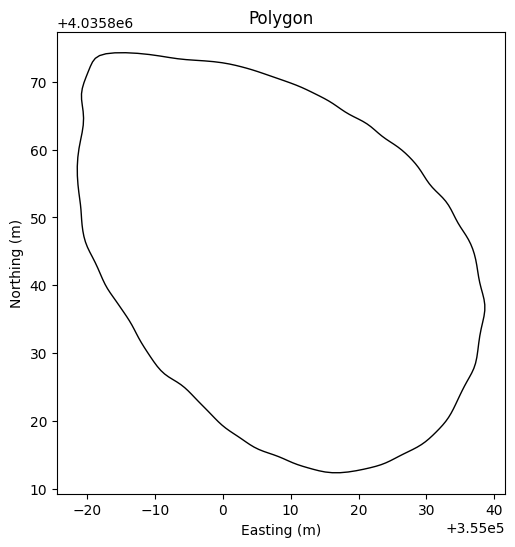

In [55]:
# Plot the final smoothed polygon
fig, ax = plt.subplots(figsize = (6, 6))
vector_gdf.plot(ax = ax, edgecolor = 'black', facecolor = 'none')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.title('Polygon')

plt.show()

In [56]:
# Save final
GeoJson_output_path = DIR / (crop_concern_val + 'Final.geojson')
vector_gdf.to_file(GeoJson_output_path, driver = 'GeoJSON')

In [59]:
vector_gdf.head()

AttributeError: 'NoneType' object has no attribute 'copy'

,geometry
0,"POLYGON ((354979.377 4035848.043, 354979.268 4..."
